In [1]:
#importing packages and identifying/importing csv file

import pandas as pd
import numpy as np
import matplotlib.dates as dates
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.filterwarnings('ignore')

# number of days to forecast
step=100

df=pd.read_csv('google_5yr.csv')

In [2]:
# profiling dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1255 non-null   object 
 1   Close   1255 non-null   float64
 2   High    1255 non-null   float64
 3   Low     1255 non-null   float64
 4   Open    1255 non-null   float64
 5   Volume  1255 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.0+ KB


In [3]:
# indentify duplicate days if any
dup=df.duplicated()
dup.value_counts()
# all false, no duplicate days

False    1255
Name: count, dtype: int64

In [4]:
df.isna().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [5]:
df.describe()

,Close,High,Low,Open,Volume
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,127.343522,128.767640,125.894397,127.286213,3.211913e+07
std,31.589957,31.873115,31.332366,31.626389,1.354981e+07
min,67.802834,69.567407,67.260929,67.693363,9.312000e+06
25%,102.415359,103.588002,101.102139,102.211330,2.333280e+07
50%,128.465805,130.137811,126.953037,128.635000,2.882800e+07
75%,147.319428,148.956410,146.023874,147.533393,3.675800e+07
max,206.142593,206.811821,202.576693,203.156027,1.274901e+08


In [6]:
df

,Date,Close,High,Low,Open,Volume
0,6/4/2020,70.378517,71.723094,69.965992,71.497169,26982000
1,6/5/2020,71.658401,71.970910,70.046107,70.445200,42642000
2,6/8/2020,72.057487,72.105256,70.885091,70.974667,33878000
3,6/9/2020,72.258530,73.040793,71.774842,71.918162,33624000
4,6/10/2020,72.886528,73.288104,72.371990,72.727787,31762000
...,...,...,...,...,...,...
1250,5/27/2025,172.899994,173.169998,170.000000,170.160004,37995700
1251,5/28/2025,172.360001,175.270004,171.910004,173.160004,34784000
1252,5/29/2025,171.860001,174.419998,170.630005,174.000000,29373800
1253,5/30/2025,171.740005,172.210007,167.440002,171.350006,52639900


In [7]:
#set day to datetime and select example dates
df['Date'] = pd.to_datetime(df['Date'])

#create other dataframes for comparing different models
df_p = df.drop(['Open', 'High', 'Low', 'Volume'], axis = 1)
df_tf = df_p

# set date column as new index
df.set_index('Date', inplace=True)
df

,Close,High,Low,Open,Volume
Date,,,,,
2020-06-04,70.378517,71.723094,69.965992,71.497169,26982000
2020-06-05,71.658401,71.970910,70.046107,70.445200,42642000
2020-06-08,72.057487,72.105256,70.885091,70.974667,33878000
2020-06-09,72.258530,73.040793,71.774842,71.918162,33624000
2020-06-10,72.886528,73.288104,72.371990,72.727787,31762000
...,...,...,...,...,...
2025-05-27,172.899994,173.169998,170.000000,170.160004,37995700
2025-05-28,172.360001,175.270004,171.910004,173.160004,34784000
2025-05-29,171.860001,174.419998,170.630005,174.000000,29373800


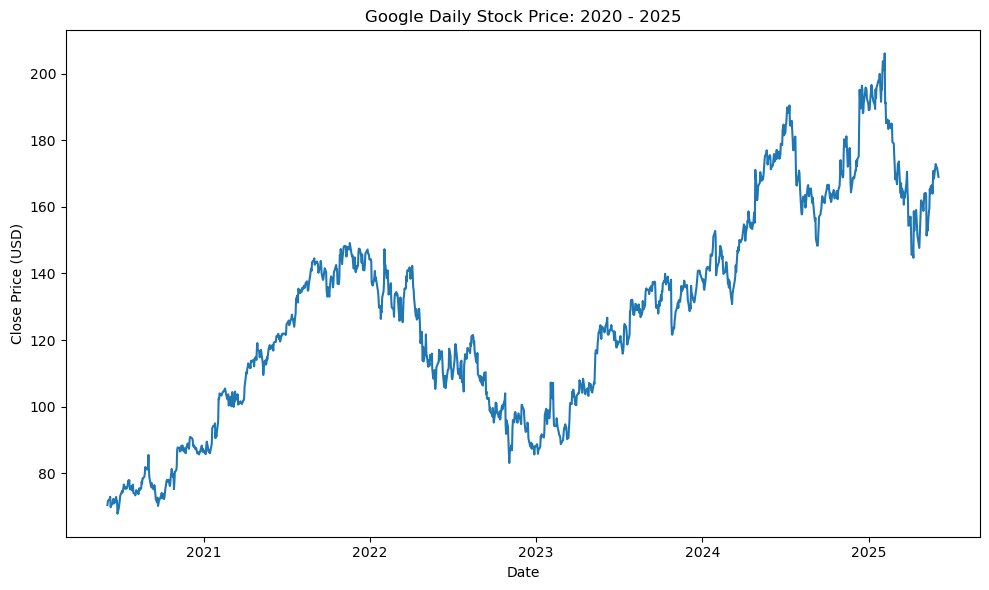

In [8]:
# plot stock price at close
plt.figure(figsize = [10,6])
plt.title("Google Daily Stock Price: 2020 - 2025")
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(df.index, df['Close'])
plt.tight_layout()
plt.show()

In [9]:
#50, 100, 200 day moving averages on 'Close'
df['MA50']  = df['Close'].rolling(window=50).mean()
df['MA100']  = df['Close'].rolling(window=100).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

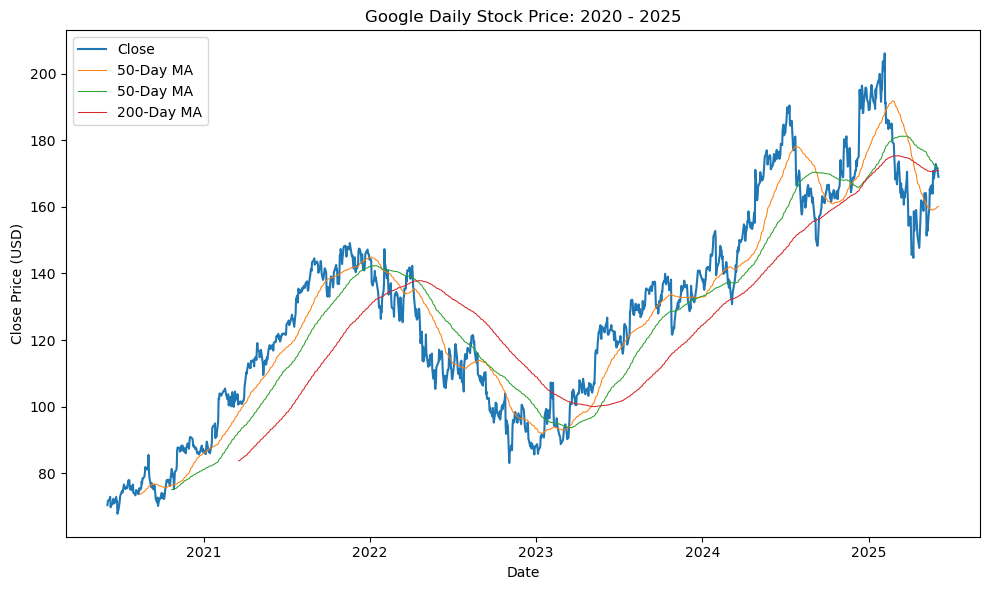

In [10]:
# plot stock price at close with moving averages
plt.figure(figsize = [10,6])
plt.title("Google Daily Stock Price: 2020 - 2025")
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(df.index, df['Close'], label='Close', lw=1.5)
plt.plot(df.index, df['MA50'], label='50-Day MA', lw=.75)
plt.plot(df.index, df['MA100'], label='50-Day MA', lw=.75)
plt.plot(df.index, df['MA200'], label='200-Day MA', lw=.75)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# augmented dicky fuller for test of stationarity
adf1 = adfuller(df.Close)

print(adf1)
# data is not stationary (p value of .55)

(-1.4714719531492582, 0.5475736126925824, 4, 1250, {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}, 5787.014333116165)


(-18.298065650080332, 2.2897350969959462e-30, 3, 1051, {'1%': -3.4365872439265366, '5%': -2.8642939151214337, '10%': -2.568236291810346}, 4964.900317696327)


<Axes: xlabel='Date'>

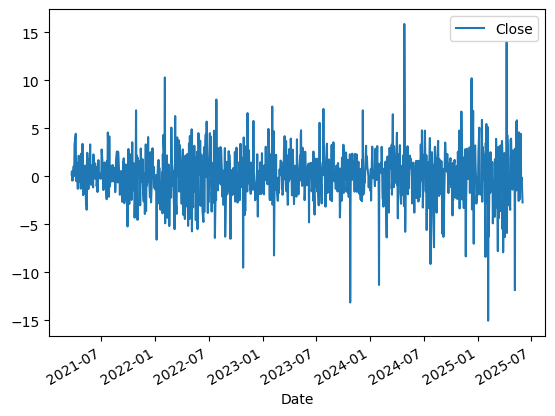

In [12]:
# need to take .diff in order to remove non-stationarity from the data
df_diff = df.diff().dropna().drop(['Open', 'High', 'Low', 'Volume', 'MA50','MA100','MA200'], axis = 1)

adf2 = adfuller(df_diff.Close)

print(adf2)
# extremely small p value, passes stationarity test
df_diff.plot()
# looks stationary as well

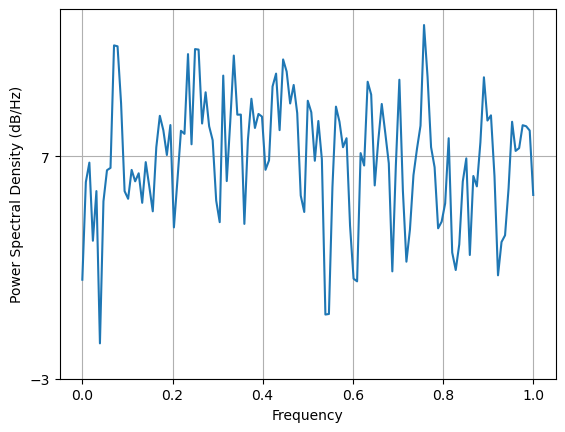

In [13]:
# spectral density plot of the differenced data
plt.psd(x=df_diff.Close);

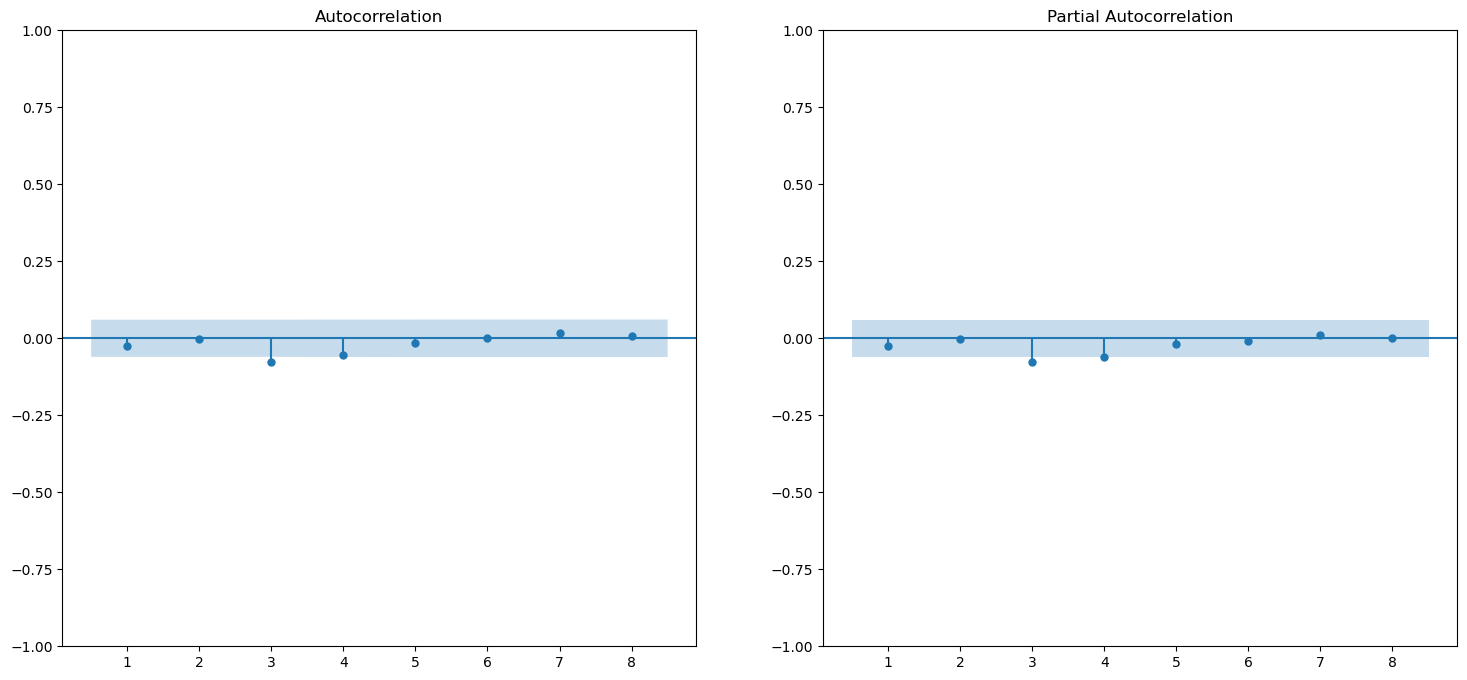

In [14]:
# create subplot for ACF and PACF of the differenced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18,8])
# use 8 lags for acf and pacf
plot_acf(df_diff, lags=8, zero=False, ax=ax1)
plot_pacf(df_diff, lags=8, zero=False,ax=ax2);

In [15]:
# split original data into train and test 
df_split=df.drop(['Open', 'High', 'Low', 'Volume', 'MA50','MA100','MA200'], axis = 1)
train, test = train_test_split(df_split, test_size=0.2, shuffle=False)
train
#confirmed that the train set contains 80% of the data

,Close
Date,
2020-06-04,70.378517
2020-06-05,71.658401
2020-06-08,72.057487
2020-06-09,72.258530
2020-06-10,72.886528
...,...
2024-05-23,172.724213
2024-05-24,174.157379
2024-05-28,175.560654


In [16]:
test
#confirmation that the test dataset picks up at the end of train and goes to the end of 2001

,Close
Date,
2024-05-31,171.679199
2024-06-03,172.346024
2024-06-04,172.963074
2024-06-05,174.575363
2024-06-06,175.889084
...,...
2025-05-27,172.899994
2025-05-28,172.360001
2025-05-29,171.860001


Go back to original without the difference and examine the seasonal component

In [17]:
# look at seasonality of the original dataset
df_decomp = df.drop(['Open', 'High', 'Low', 'Volume', 'MA50','MA100','MA200'], axis = 1)
df_decomp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-06-04 to 2025-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1255 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


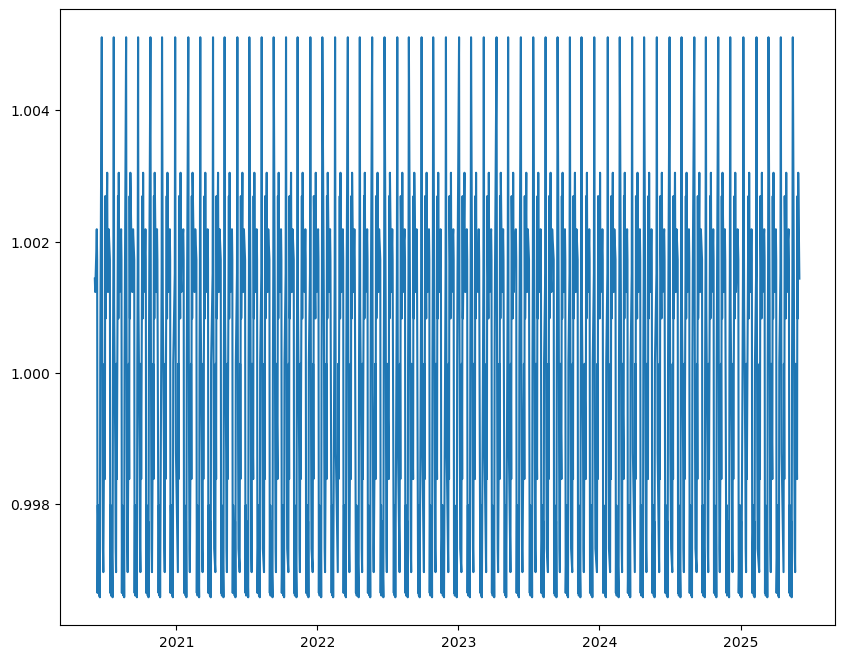

In [18]:
# set period to equal 22 for number of trading days per month seasonality
df_decomp = seasonal_decompose(df_decomp, model='multiplicative', period = 22)
plt.figure(figsize = [10,8])
# Plot seasonal component of the data
plt.plot(df_decomp.seasonal);

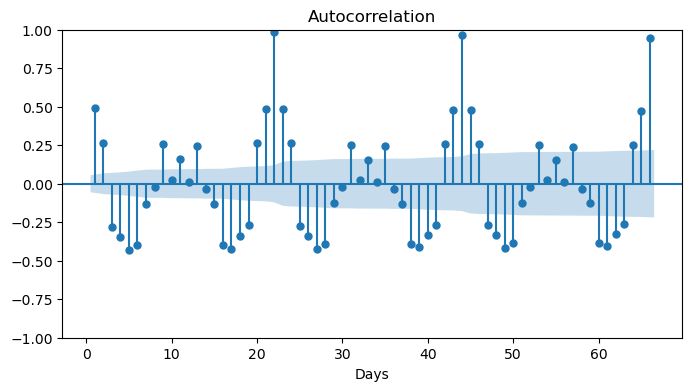

In [19]:
# look at acf lags to determine how often the seasonality repeats
fig,ax = plt.subplots(1,1,figsize=(8,4))

plot_acf(df_decomp.seasonal, ax=ax, lags=66, zero=False)
plt.xlabel('Days')
plt.show()
# monthly (every 22 trading days) seasonal component is identified in the acf below

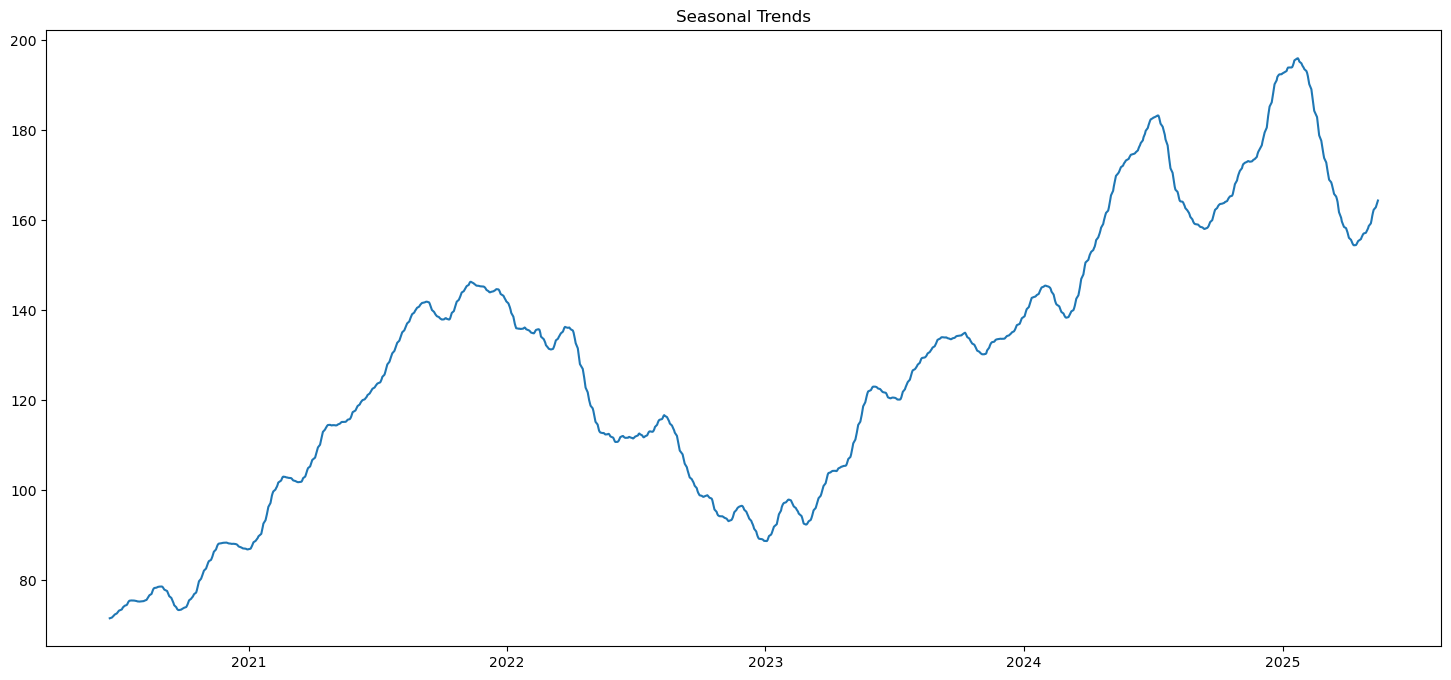

In [20]:
# plot entire decomposed graph
plt.figure(figsize = [18,8])
# Plot trend component of the data
plt.plot(df_decomp.trend)
plt.title('Seasonal Trends');

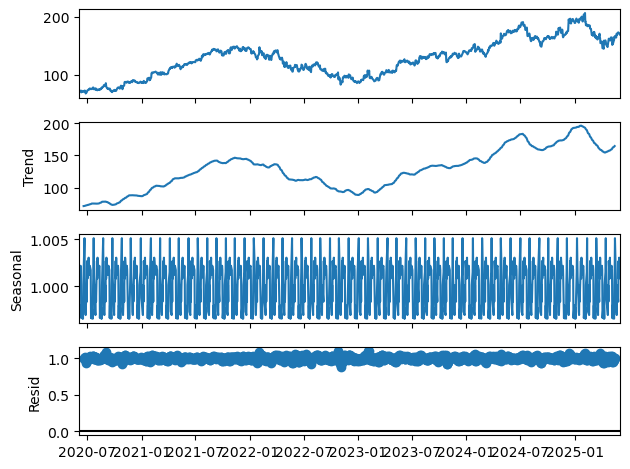

In [21]:
# all plots for decomposed time series
df_decomp.plot();

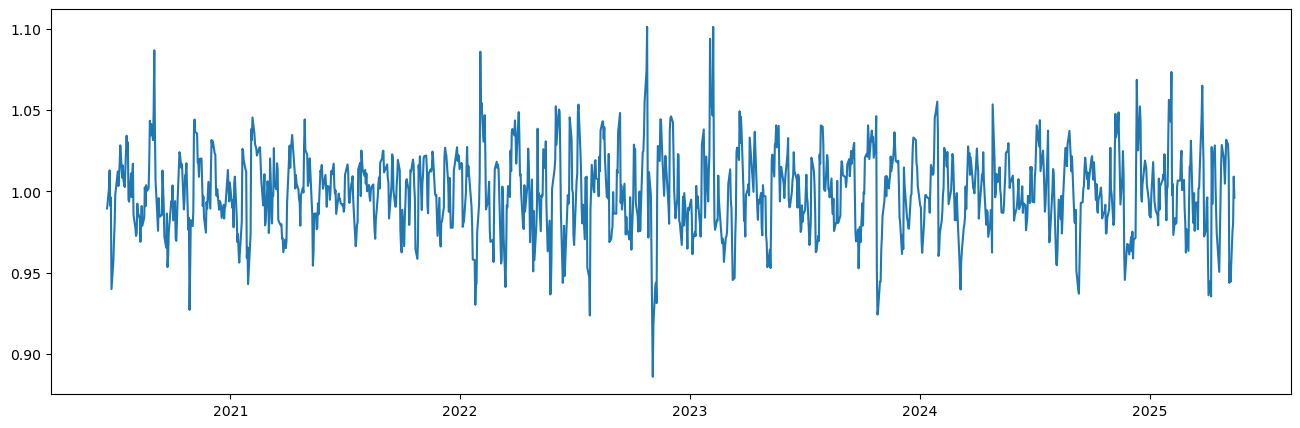

In [22]:
# confirmation of lack of trends in residual data
plt.figure(figsize = [16,5])
# Plot residual component of the data
plt.plot(df_decomp.resid);

Go back to mts_diff dataframe and use the seasonal information found to do an auto arima

In [23]:
df_diff_arima=auto_arima(df_diff['Close'], trace=True, seasonal=True)

df_diff_arima.summary()
#even though there is a weekly seasonal component, the auto_arima shows the model performs better without it

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5061.426, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5063.755, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5065.151, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5065.144, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5062.377, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5064.564, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5064.487, Time=0.50 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5062.180, Time=0.78 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5062.418, Time=0.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5062.971, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5061.635, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5061.148, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5062.685, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=5062.578, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1055
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -2524.931
Date:                Sat, 07 Jun 2025   AIC                           5059.862
Time:                        09:20:29   BIC                           5084.669
Sample:                             0   HQIC                          5069.266
                               - 1055                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0281      0.026     -1.094      0.274      -0.079       0.022
ar.L2         -0.0051      0.029     -0.172      0.863      -0.063       0.053
ar.L3         -0.0787      0.027     -2.869      0.004      -0.132      -0.025
ar.L4         -0.0582      0.027     -2.169      0.030      -0.111      -0.006
sigma2         7.0195      0.176     39.936      0.000       6.675       7.364
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               823.77
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Go back to training data and fit data to SARIMAX model with the numbers from the diff data

In [24]:
# fit sarimax model with info that was measured earlier with the differenced data
# because the prior data was differenced, the updated order for this needs to be (4,1,0) to include differencing
model=SARIMAX(train, order=(4,1,0), seasonal_order=(0,0,0,0))

model_results=model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1004
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -2237.787
Date:                Sat, 07 Jun 2025   AIC                           4485.575
Time:                        09:20:29   BIC                           4510.128
Sample:                             0   HQIC                          4494.905
                               - 1004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0376      0.027     -1.377      0.168      -0.091       0.016
ar.L2         -0.0169      0.031     -0.546      0.585      -0.078       0.044
ar.L3         -0.0548      0.028     -1.922      0.055      -0.111       0.001
ar.L4         -0.0002      0.030     -0.007      0.994      -0.058       0.058
sigma2         5.0748      0.126     40.342      0.000       4.828       5.321
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1072.26
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# forecast using the trained model against the testing data
forecast = model_results.get_forecast(steps=len(test))
mean_forecast=forecast.predicted_mean
conf_intervals=forecast.conf_int()
lower_limits=conf_intervals.loc[:,'lower Close']
upper_limits=conf_intervals.loc[:,'upper Close']

In [26]:
if len(lower_limits) == len(test):
    lower_limits.index = test.index
    upper_limits.index = test.index
    mean_forecast.index = test.index
else:
    raise ValueError("Lengths of test and confidence intervals do not match!")

In [27]:
print(mean_forecast)

Date
2024-05-31    171.364188
2024-06-03    171.452164
2024-06-04    171.654311
2024-06-05    171.642027
2024-06-06    171.634238
                 ...    
2025-05-27    171.625767
2025-05-28    171.625767
2025-05-29    171.625767
2025-05-30    171.625767
2025-06-02    171.625767
Name: predicted_mean, Length: 251, dtype: float64


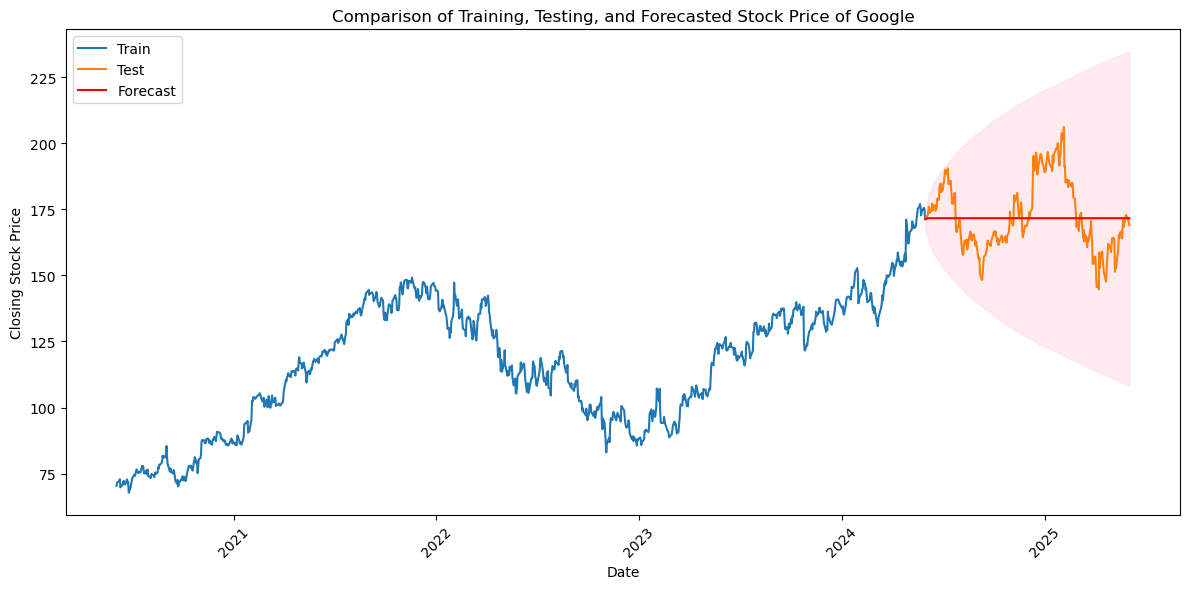

In [28]:
# plot train, test, and forecasted data
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(mean_forecast, color='r', label='Forecast')

# Restrict fill_between to forecast range only
ci_index = mean_forecast.index
plt.fill_between(ci_index, lower_limits, upper_limits, color='pink', alpha=0.3)

plt.title("Comparison of Training, Testing, and Forecasted Stock Price of Google")
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# run rmse here to test model predictions against actual testing data
rmse = mean_squared_error(test, mean_forecast, squared=False)
print(f"RMSE of forecasting model is {round(rmse, 5)}")

RMSE of forecasting model is 13.19517


Fit the entire original dataset with the SARIMAX model

In [30]:
# fit sarimax model with info that was measured earlier with the differenced data
# because the prior data was differenced, the updated order for this needs to be (1,1,0) to include differencing
# using this order drops the AIC from 1025 down to 880 indicating a better fit
final_model=SARIMAX(df_split, order=(4,1,0), seasonal_order=(0,0,0,0))

final_model_results=final_model.fit()
final_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1255
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -2935.211
Date:                Sat, 07 Jun 2025   AIC                           5880.422
Time:                        09:20:30   BIC                           5906.092
Sample:                             0   HQIC                          5890.070
                               - 1255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0312      0.023     -1.360      0.174      -0.076       0.014
ar.L2         -0.0015      0.026     -0.058      0.954      -0.053       0.050
ar.L3         -0.0782      0.024     -3.199      0.001      -0.126      -0.030
ar.L4         -0.0497      0.024     -2.075      0.038      -0.097      -0.003
sigma2         6.3183      0.140     45.023      0.000       6.043       6.593
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1186.32
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecast the data using the non-stationary data

In [31]:
last_date = df_split.index[-1]

# Generate future dates
forecast_steps = step
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')  # 'B' = business day

In [32]:
# Forecast into the future
forecast = final_model_results.get_forecast(steps=step)
mean_forecast = forecast.predicted_mean
final_conf_intervals = forecast.conf_int()

# Assign the new index
mean_forecast.index = future_dates
final_conf_intervals.index = future_dates

final_lower_limits=final_conf_intervals.loc[:,'lower Close']
final_upper_limits=final_conf_intervals.loc[:,'upper Close']

In [33]:
print(mean_forecast)

2025-06-03    169.180568
2025-06-04    169.214227
2025-06-05    169.430789
2025-06-06    169.547022
2025-06-09    169.532952
                 ...    
2025-10-14    169.496623
2025-10-15    169.496623
2025-10-16    169.496623
2025-10-17    169.496623
2025-10-20    169.496623
Freq: B, Name: predicted_mean, Length: 100, dtype: float64


In [34]:
if len(lower_limits) == len(test):
    final_lower_limits.index = mean_forecast.index
    final_upper_limits.index = mean_forecast.index
else:
    raise ValueError("Lengths of test and confidence intervals do not match!")

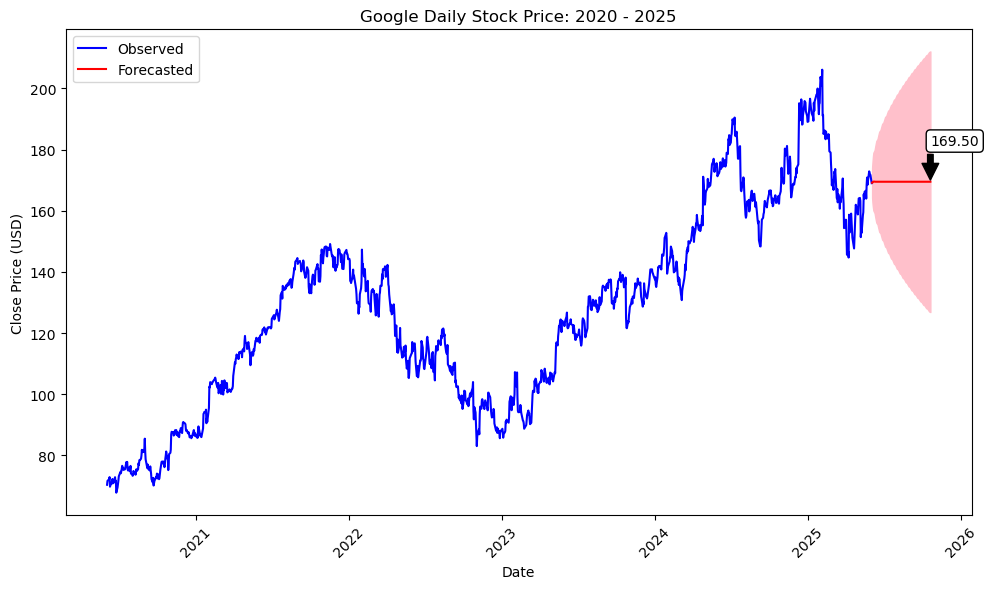

In [35]:
# plot observed data
last_date = mean_forecast.index[-1]
last_value = mean_forecast.iloc[-1]


plt.figure(figsize = [10,6])
plt.plot(df_split, color = 'blue', label='Observed')
# plot the forecasted data
plt.plot(mean_forecast, color = 'r', label='Forecast')
# Plot the confidence intervals
plt.fill_between(final_lower_limits.index, final_lower_limits, final_upper_limits, color = 'pink')
# add legend
plt.legend(['Observed', 'Forecasted'])
plt.title("Google Daily Stock Price: 2020 - 2025")
plt.xlabel("Date")
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.annotate(f'{last_value:.2f}',
             xy=(last_date, last_value),
             xytext=(last_date, last_value + 12),  # adjust vertical offset
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
plt.show()

In [36]:
# use prophet to forecast now and compare with SARIMAX model
df_p = df_p.rename(columns={'Date':'ds','Close':'y'})

In [37]:
train, test = train_test_split(df_p, test_size=0.2, shuffle=False)
train

,ds,y
0,2020-06-04,70.378517
1,2020-06-05,71.658401
2,2020-06-08,72.057487
3,2020-06-09,72.258530
4,2020-06-10,72.886528
...,...,...
999,2024-05-23,172.724213
1000,2024-05-24,174.157379
1001,2024-05-28,175.560654
1002,2024-05-29,175.063019


09:20:31 - cmdstanpy - INFO - Chain [1] start processing
09:20:31 - cmdstanpy - INFO - Chain [1] done processing


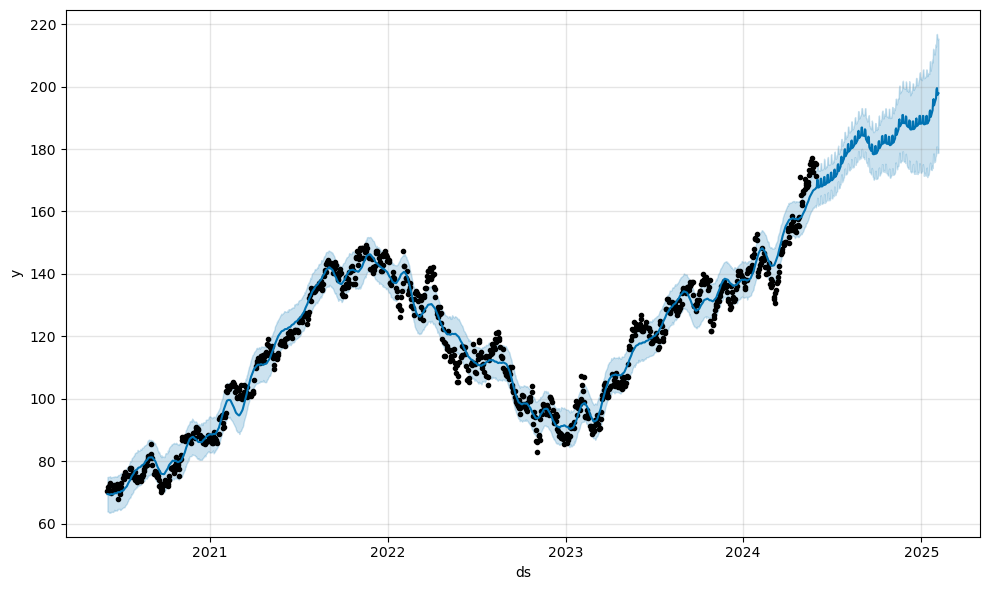

In [38]:
# Create future dates that match the test period
model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq = 'D')
forecast = model.predict(future)

# Filter forecast to match the test period only
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

model.plot(forecast)
plt.show()

In [39]:
# Align the actual and predicted values
merged = pd.merge(test, forecast[['ds', 'yhat']], on='ds', how='inner')

rmse = mean_squared_error(merged['y'], merged['yhat'], squared=False)
print(f"RMSE of forecasting model is: {rmse:.2f}")

RMSE of forecasting model is: 14.63


09:20:32 - cmdstanpy - INFO - Chain [1] start processing
09:20:32 - cmdstanpy - INFO - Chain [1] done processing


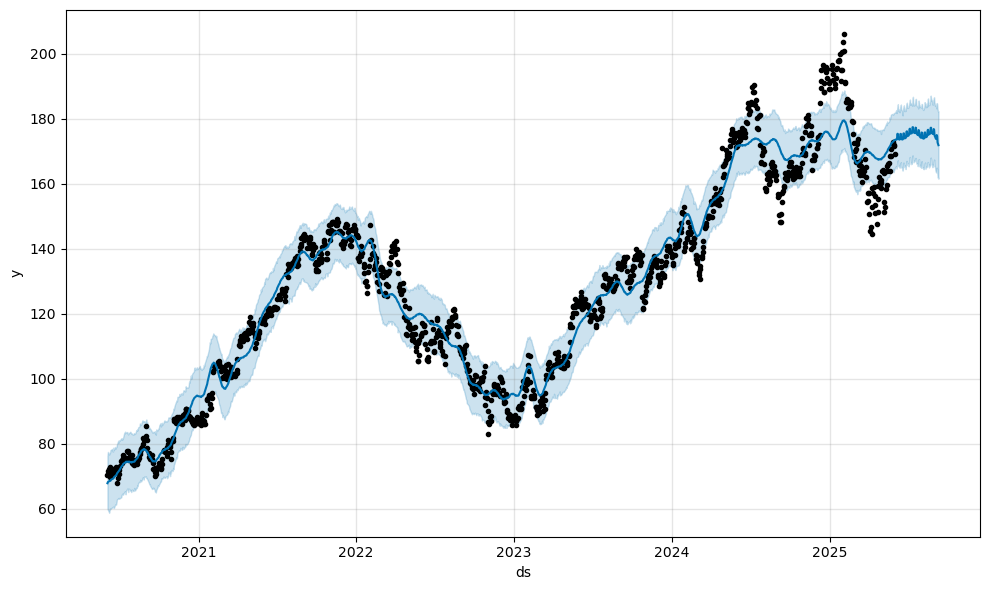

In [40]:
# Initialize and fit the model (prophet can handle seasonality, weekends, non_stationary data, etc.)
model = Prophet()
model.fit(df_p)

# Make future dataframe
future = model.make_future_dataframe(periods=step)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()

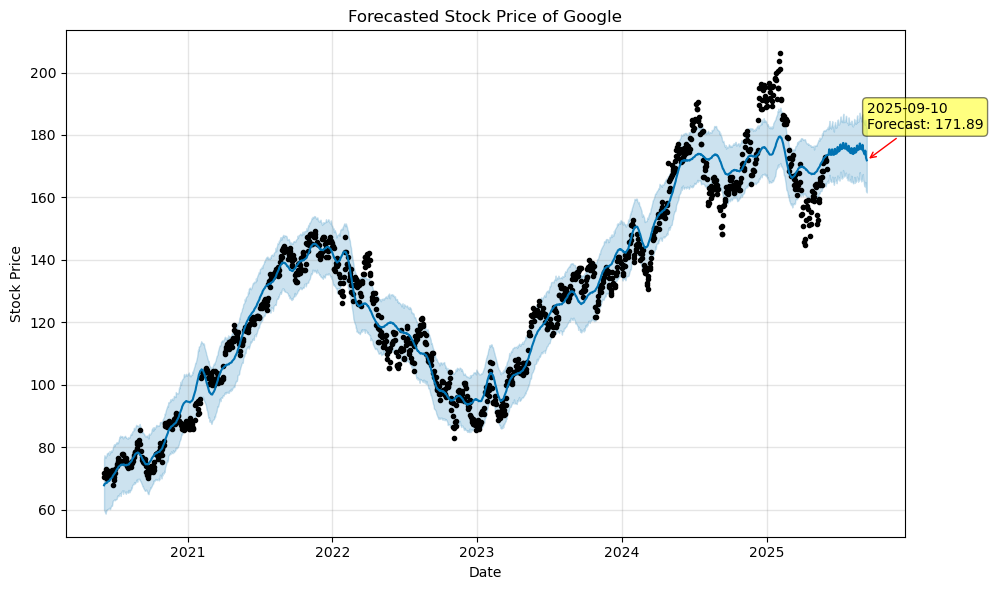

In [41]:
# Plot forecast
fig = model.plot(forecast)
ax = fig.gca()

# Annotate last forecast point
last_point = forecast.iloc[-1]
ax.annotate(
    f"{last_point['ds'].date()}\nForecast: {last_point['yhat']:.2f}",
    xy=(last_point['ds'], last_point['yhat']),
    xytext=(last_point['ds'], last_point['yhat'] + 10),
    arrowprops=dict(arrowstyle='->', color='red'),
    bbox=dict(boxstyle='round', fc='yellow', alpha=0.5),
    fontsize=10,
    color='black'
)

# Contextual labels
ax.set_title("Forecasted Stock Price of Google")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")

plt.tight_layout()
plt.show()

In [42]:
# try running previous models against LSTM neural network
# use only closing price to predict
df = df_tf[['Close']]  

# Normalize the price
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [43]:
df_tf.set_index('Date', inplace=True)
df_tf

,Close
Date,
2020-06-04,70.378517
2020-06-05,71.658401
2020-06-08,72.057487
2020-06-09,72.258530
2020-06-10,72.886528
...,...
2025-05-27,172.899994
2025-05-28,172.360001
2025-05-29,171.860001


In [44]:
# use seq len of 60 meaning that the LSTM uses previous 60 days to predict next day
seq_len=60
def create_sequences(data, seq_len=seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32, shuffle=False)

print(model.summary()) 
early_stopping= EarlyStopping(patience= 2)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0860
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0268     
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0057
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0061
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0047
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0042
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0038 
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038 
Epoch 10/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0035 
Epoch 11/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0036
Epoch 12/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0031
Epoch 13/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0032
Epoch 14/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0030 
Epoch 15/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

None


In [46]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step 


In [47]:
rmse = np.sqrt(mean_squared_error(actual, predictions))

print(f"RMSE: {rmse:.2f}")

RMSE: 8.24


In [48]:
# Flatten all data
all_data = scaler.inverse_transform(scaled_data).flatten()
predictions = predictions.flatten()

# Create forecast placeholder
forecast_plot = np.empty(len(all_data))
forecast_plot[:] = np.nan

# Align and trim predictions if they don't fit
start = train_size + seq_len
end = min(start + len(predictions), len(all_data))  # Ensure we don't go out of bounds

forecast_len = end - start  # How much room we actually have
forecast_plot[start:end] = predictions[:forecast_len]

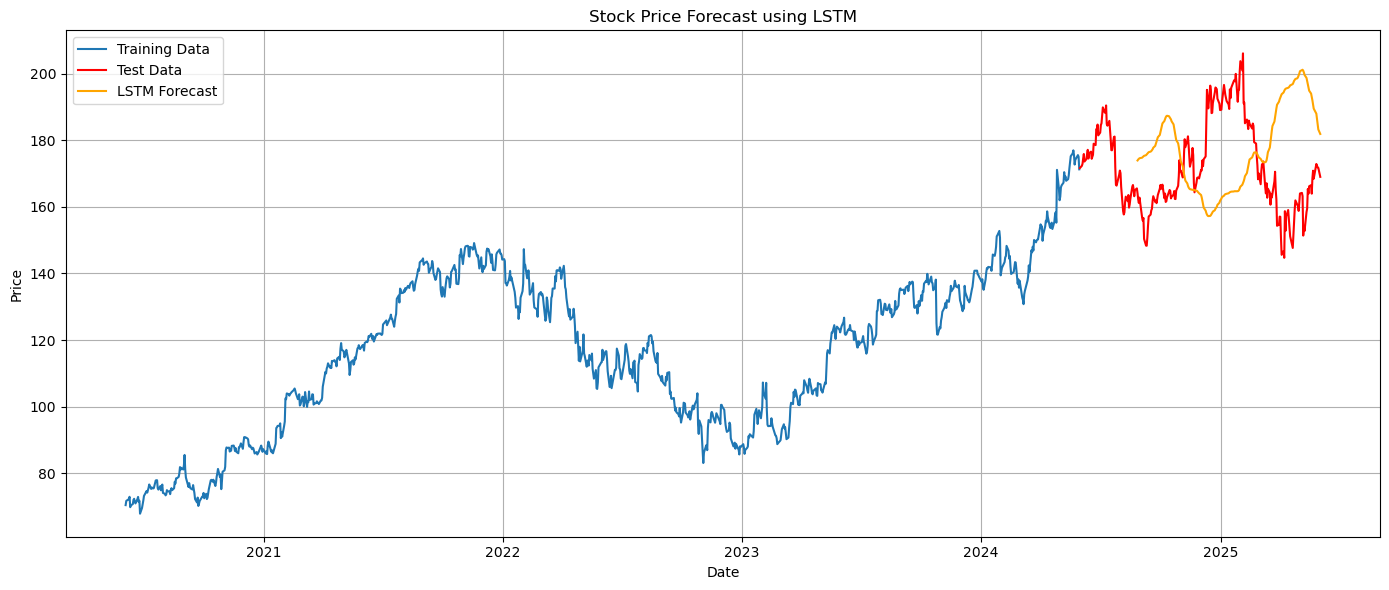

In [49]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(df_tf.index[:train_size], all_data[:train_size], label='Training Data')

# Plot test data
plt.plot(df_tf.index[train_size:], all_data[train_size:], label='Test Data', color='red')

# Plot predictions (aligned)
plt.plot(df_tf.index, forecast_plot, label='LSTM Forecast', color='orange')

plt.title("Stock Price Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Prepare data
full_data = df_tf[['Close']].values
scaler = MinMaxScaler()
scaled_full = scaler.fit_transform(full_data)

X_full = []
y_full = []

for i in range(seq_len, len(scaled_full)):
    X_full.append(scaled_full[i - seq_len:i])
    y_full.append(scaled_full[i])

X_full = np.array(X_full)             
y_full = np.array(y_full)

In [51]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error')# Fit model
model.fit(X_full, y_full, epochs=40, batch_size=32, shuffle=False)

# Print model summary
print(model.summary())

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1472
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0337 
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0091
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0081
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0068
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0065
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0054 
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0049 
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0041
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0034 
Epoch 13/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0032
Epoch 14/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0033
Epoch 15/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0032

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

None


In [52]:
last_seq = X_full[-1]  # Last 60-day sequence used for prediction
last_seq = last_seq.reshape(1, seq_len, 1)

future_predictions_scaled = []

for _ in range(step):
    pred = model.predict(last_seq, verbose=0)
    future_predictions_scaled.append(pred[0, 0])

    # Update sequence: remove first, append new prediction
    last_seq = np.append(last_seq[:, 1:, :], [[[pred[0, 0]]]], axis=1)

In [53]:
future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions_scaled)

In [54]:
last_date = df_tf.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=step)

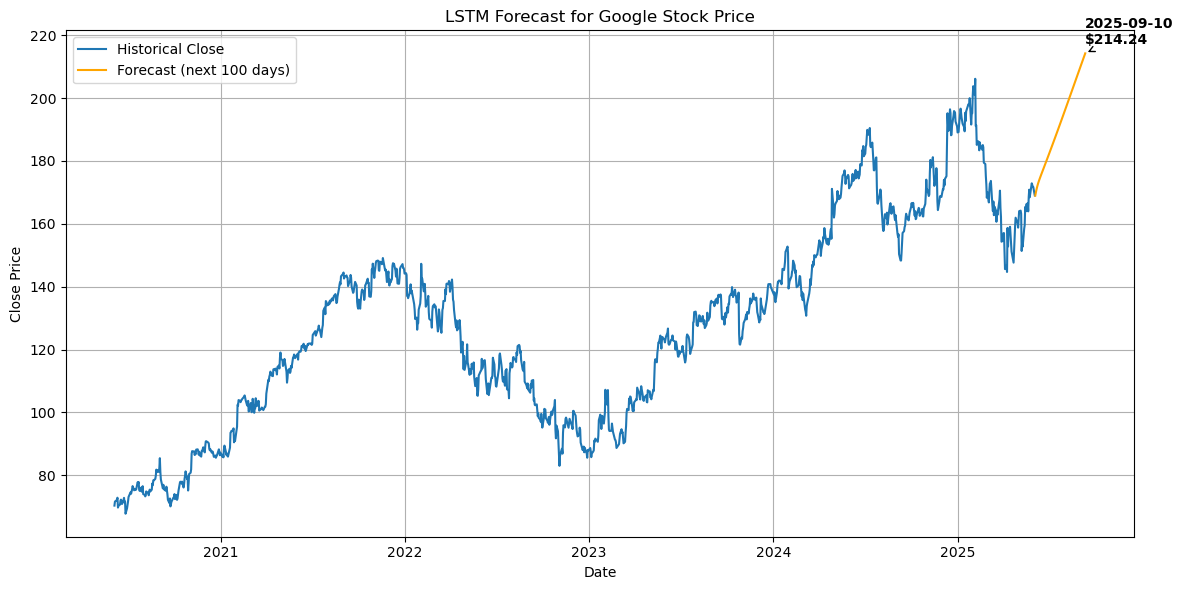

In [59]:
# Plot past actuals
plt.figure(figsize=(12, 6))
plt.plot(df_tf['Close'], label='Historical Close')

# Plot forecast
forecast_series = pd.Series(future_predictions.flatten(), index=future_dates)
plt.plot(forecast_series, label='Forecast (next 100 days)', color='orange')

last_forecast_date = forecast_series.index[-1]
last_forecast_price = forecast_series.iloc[-1]

label_text = f"{last_forecast_date.strftime('%Y-%m-%d')}\n${last_forecast_price:.2f}"

plt.annotate(
    label_text,                            
    xy=(last_forecast_date, last_forecast_price),             
    xytext=(last_forecast_date, last_forecast_price + 3),     
    arrowprops=dict(arrowstyle="->", color='black'),         
    fontsize=10,
    color='black',
    weight='bold')

plt.title('LSTM Forecast for Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()